## Model-Agnostic Meta-Learning

Based on the paper: <i>Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks</i>. Data from this [notebook](https://github.com/hereismari/tensorflow-maml/blob/master/maml.ipynb): sinusoid dataset of sine waves with different amplitude and phase, representing different "tasks". These are shuffled prior to batching, representing the task sampling step.

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input,Dense,Dropout,Activation
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy,MeanSquaredError
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score,mean_squared_error
from sklearn.utils import shuffle

### Gather data

In [2]:
sin_x = np.load("../data/other/sin_x.npy")
sin_y = np.load("../data/other/sin_y.npy")

sin_x_test = np.load("../data/other/sin_x_test.npy")
sin_y_test = np.load("../data/other/sin_y_test.npy")

train_x,test_x = sin_x[:10000],sin_x[10000:]
train_y,test_y = sin_y[:10000],sin_y[10000:]

train_x,train_y = shuffle(train_x,train_y)
test_x,test_y = shuffle(test_x,test_y)
print(train_x.shape,train_y.shape)
print(sin_x_test.shape,sin_y_test.shape)

(10000, 1) (10000, 1)
(100, 1) (100, 1)


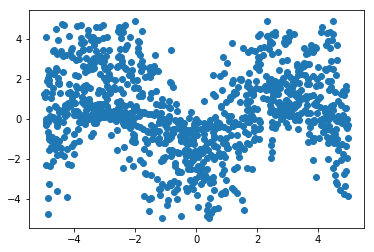

In [3]:
plt.scatter(train_x[:1000],train_y[:1000])
plt.show()

### Modeling

In [4]:
def get_model():
    """ Model instantiation
    """
    x = Input(shape=(1))
    h = Dense(50,activation="relu")(x)
    h = Dense(50,activation="relu")(h)
    o = Dense(1,activation=None)(h)
    
    model = Model(inputs=x,outputs=o)
    return model

In [5]:
n_epochs = 100
batch_size = 25
meta_optimizer = Adam(0.01)
meta_model = get_model()

for epoch_i in range(n_epochs):
    
    losses = []
    for i in range(0,len(train_x[0]),batch_size):
        task_train_x,task_train_y = train_x[i:i+batch_size],train_y[i:i+batch_size]
        task_test_x,task_test_y = train_x[i:i+batch_size],train_y[i:i+batch_size]
    
        with tf.GradientTape() as meta_tape: # optimization step
                
            with tf.GradientTape() as tape:
                task_train_pred = meta_model(task_train_x) # this cannot be done with model_copy
                task_train_loss = MeanSquaredError()(task_train_y,task_train_pred)
            gradients = tape.gradient(task_train_loss, meta_model.trainable_variables)

            model_copy = get_model()
            model_copy.set_weights(meta_model.get_weights())
            k=0 # gradient descent this way does not break gradient flow from model_copy -> meta_model
            for i in range(1,len(model_copy.layers)): # first layer is input
                model_copy.layers[i].kernel = meta_model.layers[i].kernel-0.01*gradients[k]
                model_copy.layers[i].bias = meta_model.layers[i].bias-0.01*gradients[k+1]
                k+=2

            task_test_pred = model_copy(task_test_x)
            task_test_loss = MeanSquaredError()(task_test_y,task_test_pred)
        
        gradients = meta_tape.gradient(task_test_loss,meta_model.trainable_variables)
        meta_optimizer.apply_gradients(zip(gradients,meta_model.trainable_variables))
        losses.append(float(task_test_loss))
    
    if (epoch_i+1)%10==0 or epoch_i==0:
        print("Epoch {}: {}".format(epoch_i+1,sum(losses)/len(losses)))

Epoch 1: 6.141565322875977
Epoch 10: 5.5814290046691895
Epoch 20: 5.013033390045166
Epoch 30: 4.59114408493042
Epoch 40: 4.133002281188965
Epoch 50: 3.6128015518188477
Epoch 60: 3.2390520572662354
Epoch 70: 2.9024481773376465
Epoch 80: 2.571303129196167
Epoch 90: 2.3460581302642822
Epoch 100: 2.1538503170013428
